In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

Create the Data

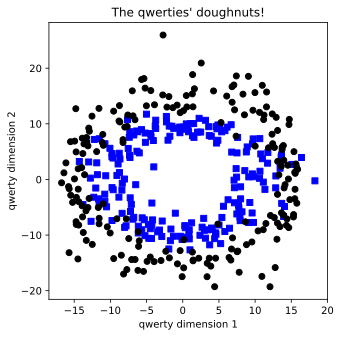

In [2]:
nPerClust=200

th=np.linspace(0,4*np.pi,nPerClust)
r1=10
r2=15

#generate the data
a=[r1*np.cos(th)+np.random.randn(nPerClust)*3, 
   r1*np.sin(th)+np.random.randn(nPerClust)]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]
#r1*np.cos(th) and r1*np.sin(th) create a perfect circle of radius r1.,np.random.randn(...) adds Gaussian noise to spread the points

#true labels
labels_np=np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))
#stack 200 zeros on top of 200 ones. np.zeros((rows,columns))

#concatenate into a matrix
data_np=np.hstack((a,b)).T
# data_np is a (400 × 2) array where  each row = [x, y] coordinate of one sample.

#converting into pytorch tensor
data=torch.tensor(data_np).float()
labels=torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()





In [3]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then we  convert them into PyTorch Datasets 
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally we them  translate into dataloader objects to train the model in batches
batchsize    = 16 
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [4]:
class theModelClass(nn.Module):
  def __init__(self,dropoutRate):
    super().__init__()

    ### layers
    self.input  = nn.Linear(  2,128)
    self.hidden = nn.Linear(128,128)
    self.output = nn.Linear(128, 1)

    # parameters
    self.dr = dropoutRate

  # forward pass
  def forward(self,x):

    # pass the data through the input layer
    x = F.relu( self.input(x) )

    # dropout after input layer
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode

    # pass the data through the hidden layer
    x = F.relu( self.hidden(x) )

    # dropout after hidden layer
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode

    # output layer
    x = self.output(x)
    # no dropout here!!
    return x
     

In [5]:
def createANewModel(dropoutrate):

  # grab an instance of the model class
  ANNQC = theModelClass(dropoutrate)

  # loss function
  lossfun = nn.BCEWithLogitsLoss() #Binary Cross-Entropy loss with a sigmoid layer built in.

  # optimizer
  optimizer = torch.optim.SGD(ANNQC.parameters(),lr=.002)

  return ANNQC,lossfun,optimizer

In [6]:
# train the model

# training parameter
numepochs = 1000

# NOTE: this time, the model, lossfun, and optimizer are inputs into the function!
def trainTheModel(ANNQC,lossfun,optimizer):

  # initialize accuracies as empties 
  trainAcc = []
  testAcc  = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch training mode on .We should always place this inside the beginning of loop of the epoch
    ANNQC.train()

    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNQC(X)
      loss = lossfun(yHat,y)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
    # end of batch loop.

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    ANNQC.eval() # switch training off
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = ANNQC(X)
    testAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )

  # function output
  return trainAcc,testAcc


In [7]:
#creating the model
dropoutrate = .0
ANNQC,lossfun,optimizer = createANewModel(dropoutrate)

# train the model
trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

In [8]:
# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')
     

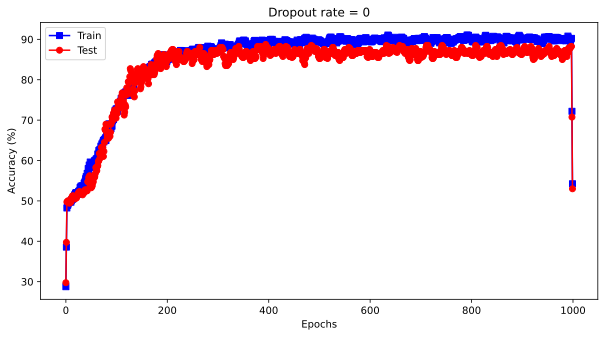

In [9]:
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

In [10]:

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # create and train the model
  ANNQC,lossfun,optimizer = createANewModel(dropoutRates[di])
  trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

  # store accuracies from last 100 epochs
  results[di,0] = np.mean(trainAcc[-100:])
  results[di,1] = np.mean(testAcc[-100:])

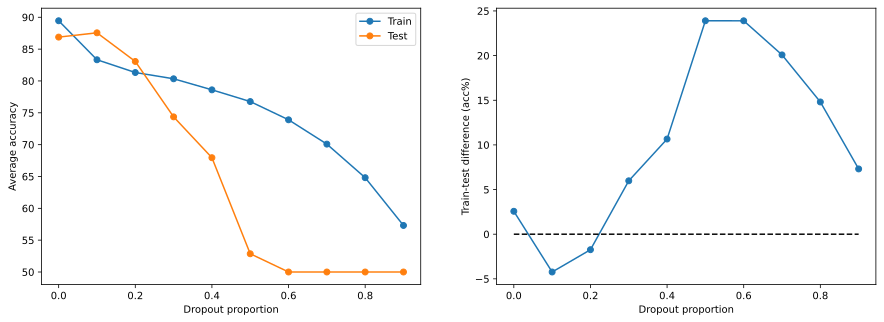

In [11]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

Conclusion:

In this experiment, we systematically evaluated the impact of varying dropout regularization rates on the performance of a feedforward neural network trained for binary classification of two spiral-shaped clusters. Dropout rates ranging from 0.0 to 0.9 were tested to analyze their effect on both training and testing accuracies across 1000 epochs.

Empirical results demonstrated that the maximum training and testing accuracies were achieved at a dropout rate of 0.0, i.e., when no dropout was applied. As the dropout rate increased, there was a progressive decline in both accuracies, accompanied by a larger disparity between training and testing performance, particularly noticeable around p = 0.5.

This widening gap indicates that higher dropout rates introduced excessive regularization, leading to underfitting of the model. In contrast, the model without dropout maintained stable convergence and superior generalization for this dataset. Therefore, under the current architecture and data complexity, dropout regularization was not beneficial and instead degraded model performance.

From a theoretical perspective, this behavior can be attributed to the low complexity and small size of the dataset, where the model did not suffer from overfitting initially. Dropout, by randomly deactivating neurons during training, effectively reduced the model’s representational capacity. Since the base model already had sufficient regularization through its architecture and data distribution, additional dropout only hindered learning. Thus, the experiment suggests that dropout should be applied judiciously, primarily when models exhibit signs of overfitting or are trained on high-dimensional datasets.
